In [4]:
!pip install tensorflow==2.15.0

# Transfer Learning with TensorFlow Part 3: Scaling Up ( 🍔 👁 Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food 101 (101 total classes of food).

Our goal is to beat the origianl Food101 paper with 10% of the training data (leveraging the power of deep learning).

Our baseline to beat it 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've create a series of helper functions to do different tasks, le'ts download them.

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-23 10:30:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-12-23 10:30:47 (15.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it

The data we're downloading comes from the original Food101 dataset but has been preprocesses using the image_data_modification notebook.

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-12-23 10:30:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   113MB/s    in 12s     

2024-12-23 10:31:02 (126 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [9]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories an

In [10]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False)   # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 Food classes


Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build dta augmentation right into the model
* Build a headless (no top layer) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [11]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True, #save only the model weights
                                                         monitor="val_accuracy",  #save the model weights which score the best validation accuracy
                                                         save_best_only = True)   # only keep the best model weights on file (delete the rest)

In [12]:
# Create data augmentation layer to incoporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
    # layers.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like REsNet50
], name = "data_augmentation")

On the models the inputs can go inside the brackets. On layers we need to pass the X on the outside.

In [13]:
# Set up the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # frezze all of the patterns that our pre_trained model has learned

# Set up model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name = "input_layer")
x = data_augmentation(inputs) #augment images (only during training phase)
x = base_model(x, training = False) #put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # because it's a layer we need to pass the X on the outside
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
# Get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [15]:
# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 158s 619ms/step - loss: 3.3739 - accuracy: 0.2738 - val_loss: 2.5386 - val_accuracy: 0.4449
Epoch 2/5
237/237 [==============================] - 103s 432ms/step - loss: 2.2038 - accuracy: 0.4945 - val_loss: 2.0858 - val_accuracy: 0.4966
Epoch 3/5
237/237 [==============================] - 95s 397ms/step - loss: 1.8227 - accuracy: 0.5609 - val_loss: 1.9069 - val_accuracy: 0.5236
Epoch 4/5
237/237 [==============================] - 81s 340ms/step - loss: 1.6063 - accuracy: 0.6132 - val_loss: 1.8033 - val_accuracy: 0.5387
Epoch 5/5
237/237 [==============================] - 78s 329ms/step - loss: 1.4483 - accuracy: 0.6467 - val_loss: 1.7833 - val_accuracy: 0.5392


In [16]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6007 - accuracy: 0.5794


[1.600677728652954, 0.5794059634208679]

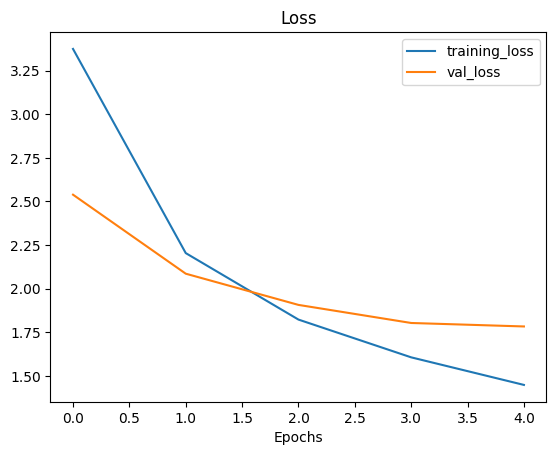

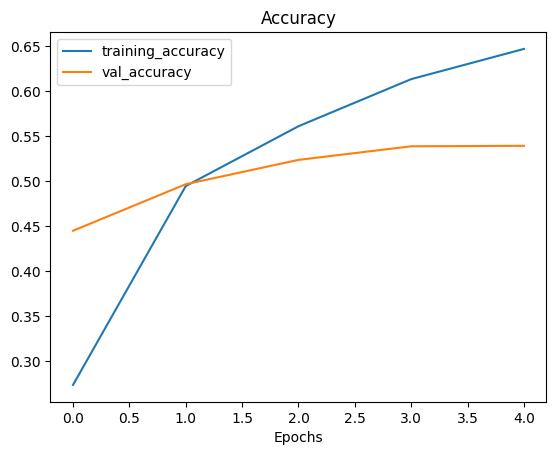

In [17]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing to weel on the training data and not generalizing to useen data)

## Fine-tuning

In [18]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer  in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# Recompile model with lower learnign rate (it's typically best practice to lower the learning rate when fine-tuning )
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [20]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [21]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [22]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Refit the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.25*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 82s 317ms/step - loss: 1.2117 - accuracy: 0.6871 - val_loss: 1.7185 - val_accuracy: 0.5381
Epoch 6/10
237/237 [==============================] - 76s 321ms/step - loss: 1.0957 - accuracy: 0.7056 - val_loss: 1.7107 - val_accuracy: 0.5454
Epoch 7/10
237/237 [==============================] - 75s 315ms/step - loss: 1.0159 - accuracy: 0.7277 - val_loss: 1.7121 - val_accuracy: 0.5452
Epoch 8/10
237/237 [==============================] - 65s 272ms/step - loss: 0.9448 - accuracy: 0.7442 - val_loss: 1.6943 - val_accuracy: 0.5495
Epoch 9/10
237/237 [==============================] - 57s 237ms/step - loss: 0.8845 - accuracy: 0.7634 - val_loss: 1.6913 - val_accuracy: 0.5555
Epoch 10/10
237/237 [==============================] - 56s 234ms/step - loss: 0.8292 - accuracy: 0.7780 - val_loss: 1.7075 - val_accuracy: 0.5520


In [23]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 55s 69ms/step - loss: 1.5137 - accuracy: 0.6017


[1.513672947883606, 0.6017029881477356]

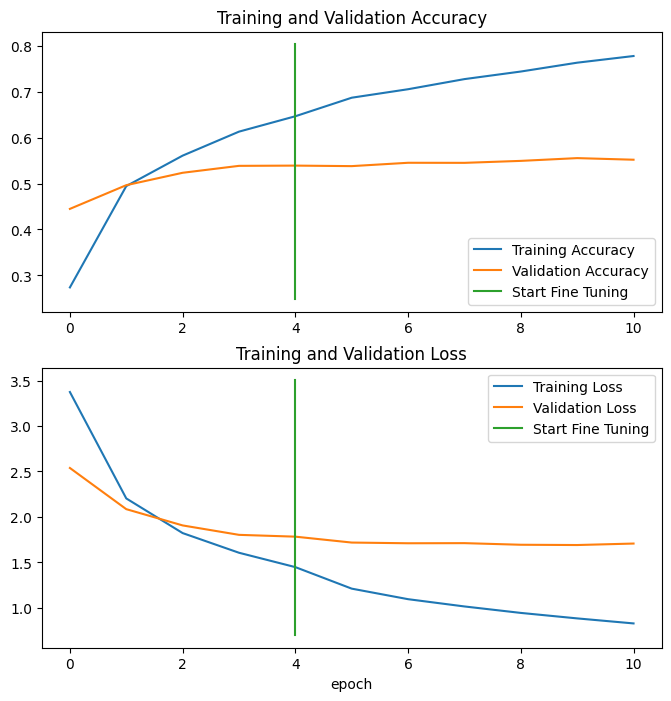

In [24]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [25]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [26]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")
loaded_model

In [27]:
# Evaluate loaded model and compare performance to pre-savedmodel
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.5137 - accuracy: 0.6017


[1.513672947883606, 0.6017029881477356]

In [28]:
# The results from the model above should be very similalr to the results below
all_classes_10_percent_fine_tune_results

[1.513672947883606, 0.6017029881477356]

## Evaluating the performance of the big dog model across all differente classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [29]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all prediction are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-12-23 10:54:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   184MB/s    in 0.2s    

2024-12-23 10:54:36 (184 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [30]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [31]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [32]:
# Evaluate loaded model (the one we jsut downloaed on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 72ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [33]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 61s 75ms/step


In [34]:
# How many predictions are there?
len(preds_probs)

25250

In [35]:
# What's te shape of our predictions?
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [37]:
# What does the first prediction probabilty array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [38]:
# We get one prediction probability per class (in our case, there's 101 prediction probabilites)
print(f"Number of predictions probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]} ")
print(f"The class with the highest predicted proability by the model for sample 0: {preds_probs[0].argmax()} ")

Number of predictions probabilites for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

In [39]:
# GEt the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#how do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [40]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [41]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0, 1,....,0,0,0], we want the index value where the "1 occurs"
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
# how many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [43]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [44]:
# Let's try scikit-learn accuracy score function and see what it comes up
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [45]:
# Does  this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [46]:
from helper_functions import make_confusion_matrix

In [47]:
# Get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [48]:
# we need to make some changes to our function to ensure x-labels are vertically
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [49]:
make_confusion_matrix(y_true= y_labels,
                      y_pred= pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size = 20,
                      savefig=True)

Output hidden; open in https://colab.research.google.com to view.

## Let's keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try out.

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [51]:
# GEt a dictionary of the classification report
classification_report_dict = classification_report(y_labels,pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

Let's plot all of our classes F1-scores...

In [52]:
# create an empty dictionary
class_f1_scores={}
# loop through classification report dictionary itmes
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

In [53]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

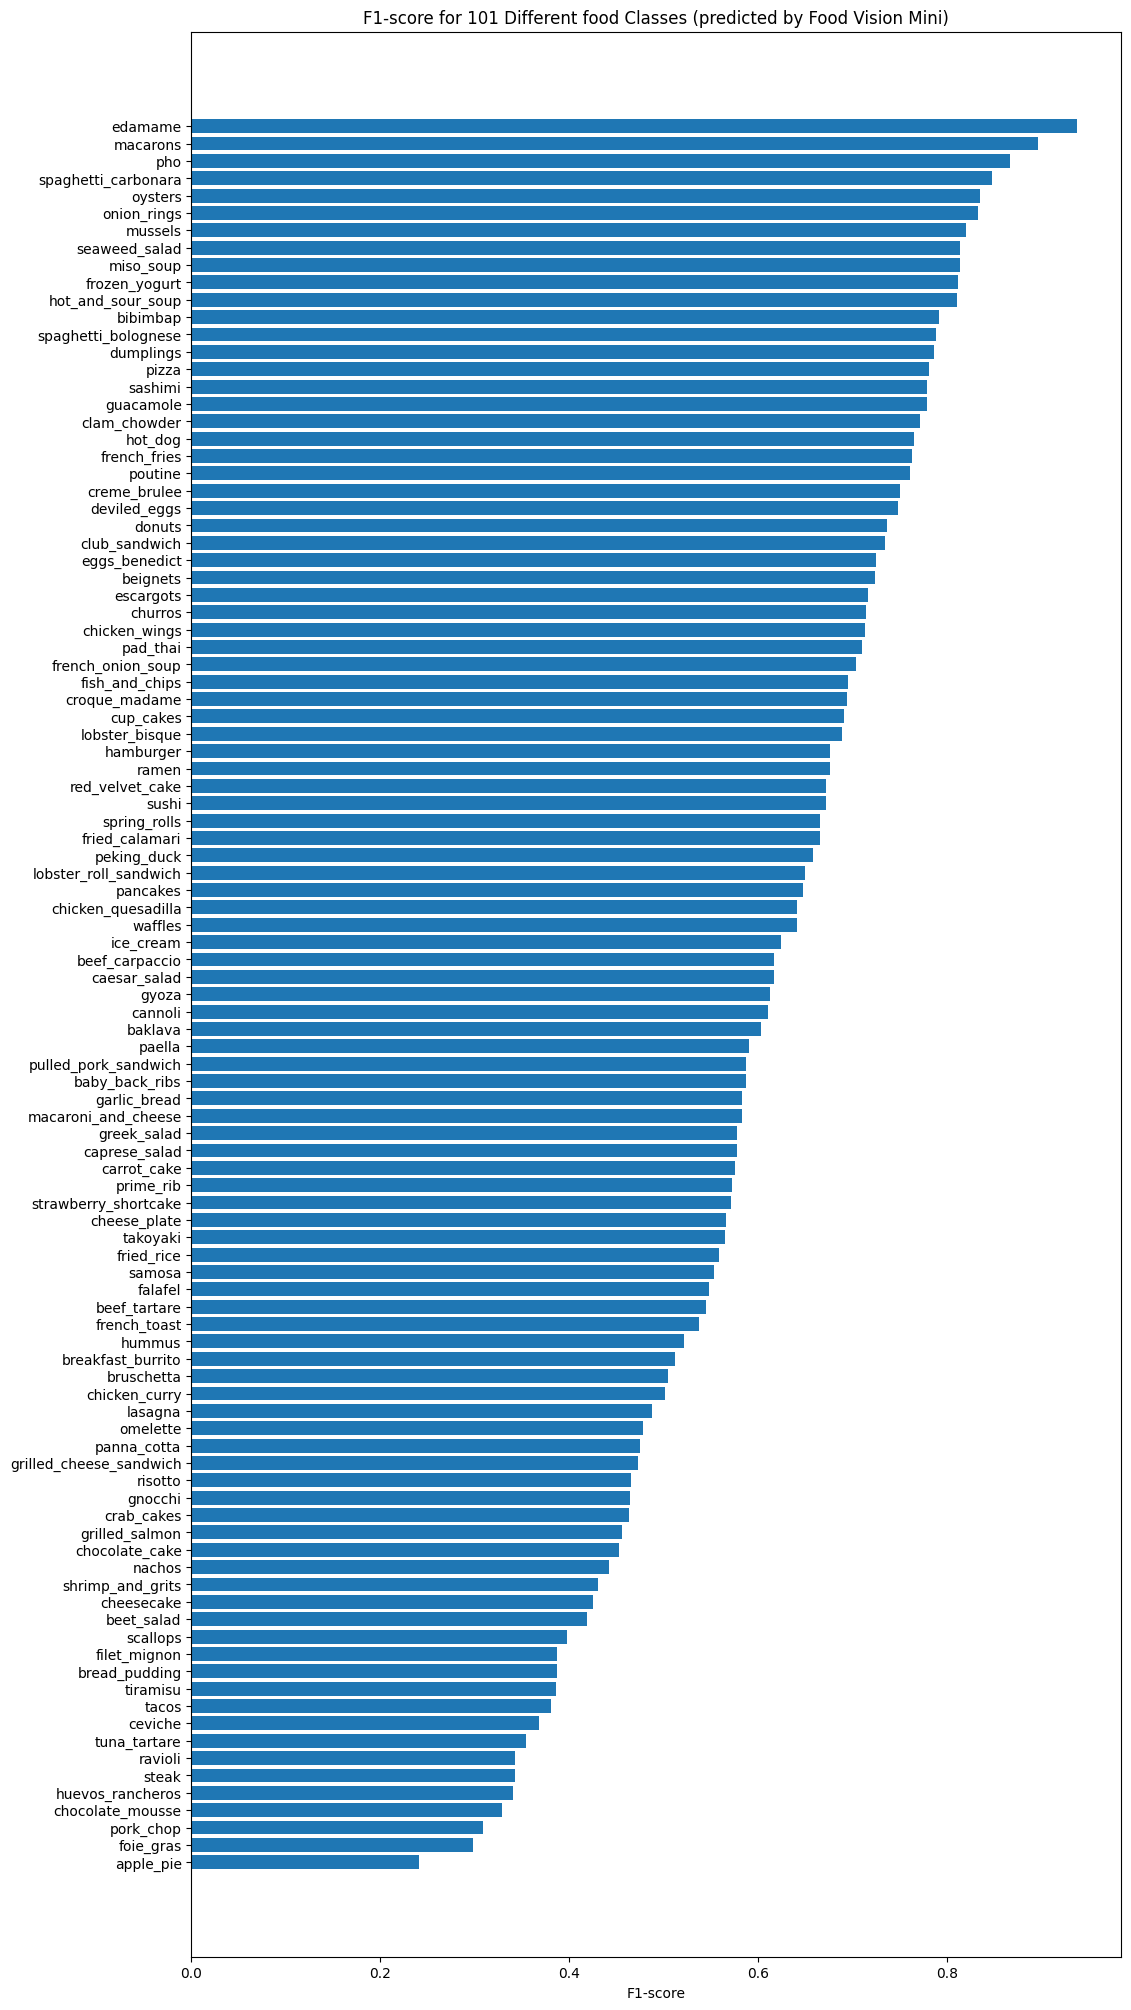

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) #get f1scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different food Classes (predicted by Food Vision Mini)")
ax.invert_yaxis();# reverse the order of our plot

## Visualizing predictions on test images

Now, this is the real test. How does our model go on food images, not even in our test data set (images of our own, we'll see this later on)?.

To visualize our model's predictions on our own images, we'll need a funtion to load and prepreocess images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image_resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [55]:
# Create a function to load and prepare images
def load_and_prep_images(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specfied
  shape (img_shape, img_shape, color_channels=3)

  Arg:
    filename (str): path to target image
    image_shape (int): height /width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all of the values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFow



Now we've got a function to load and preperare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on the loaded images
3. Plot the original images along withe the model's predictions, prediction probability and truth label.

1/1 [==============================] - 0s 25ms/step


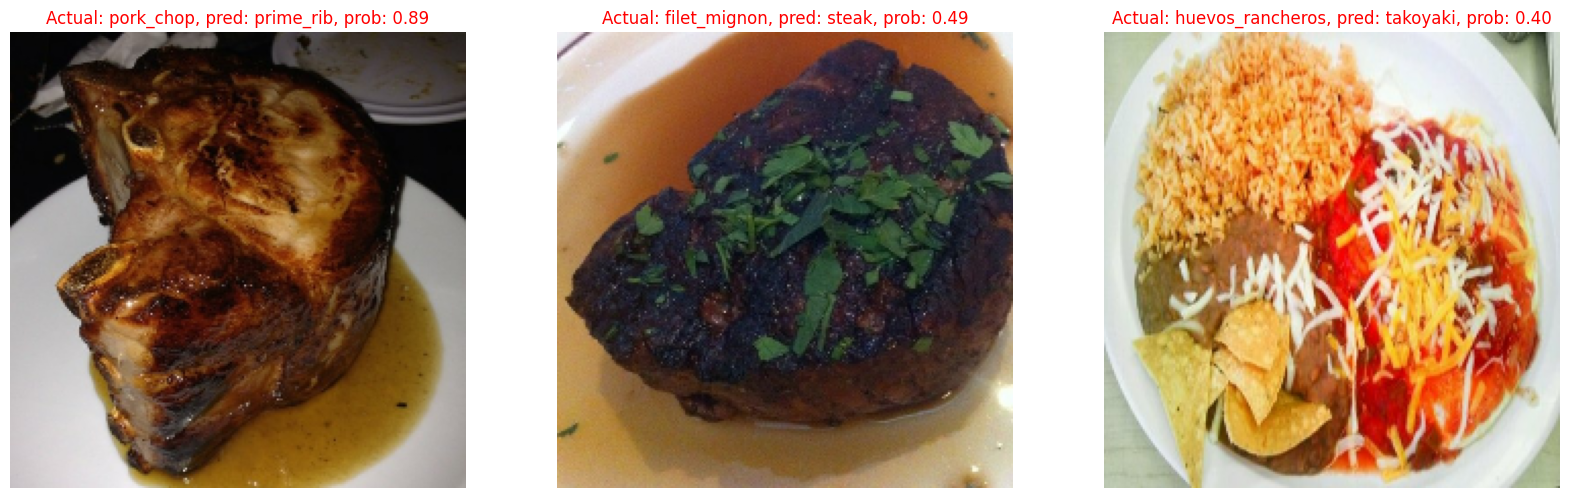

In [56]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20,15))
for i in range(3):
  # Choose a random image(s) from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir  + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_images(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabilites array
  pred_class = class_names[pred_prob.argmax()] #get highest prediction probability index

  # plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:# if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground trurth labels, predicted classes (from our model), max predictions probabilities, prediction class names,ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the predictions)
4. Sort the DataFrame based on wrong predictions (have the higest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilites but have the wrong prediction.

In [62]:
# 1. GEt all of the images file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [63]:
# 2. Create a dataframe of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1), # get the max predictiion probability value
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501951          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [64]:
# 3. Find out in our datafame which predicionts are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [65]:
# 4. Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

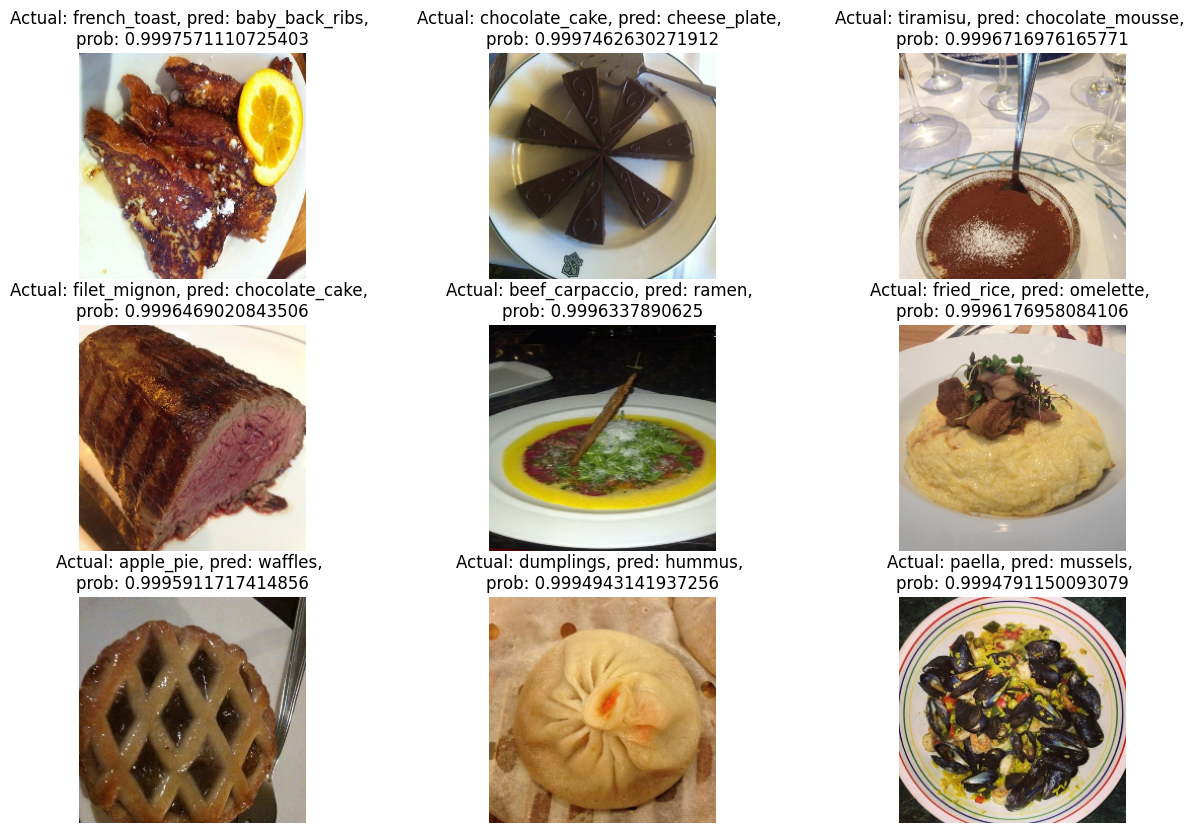

In [75]:
# 5. Visualize the test data samples which have the wrong predictions but highest pred_probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index: start_index +images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_images(row[1], scale=False)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False);


## Test out the big dog model on our custom images

In [76]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("/content/custom_food_images.zip")

--2024-12-23 11:45:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  56.4MB/s    in 0.2s    

2024-12-23 11:45:13 (56.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [80]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

1/1 [==============================] - 0s 28ms/step


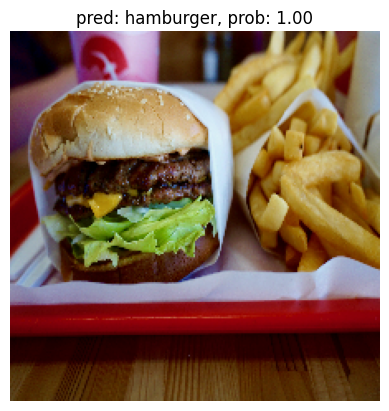

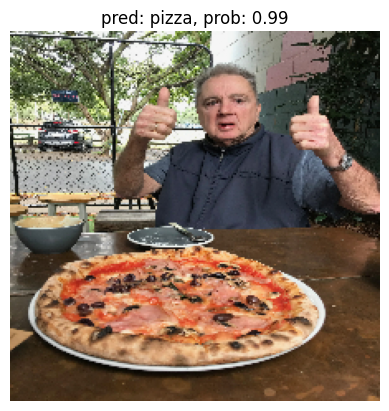

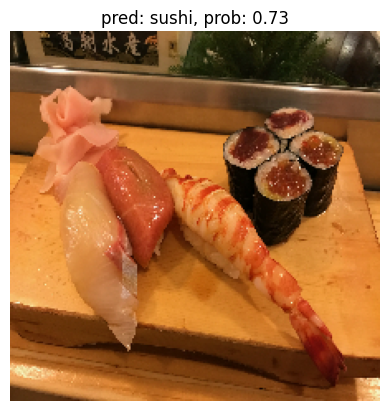

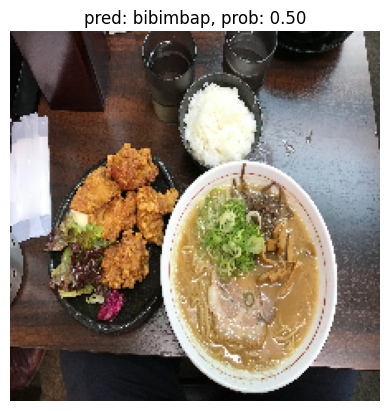

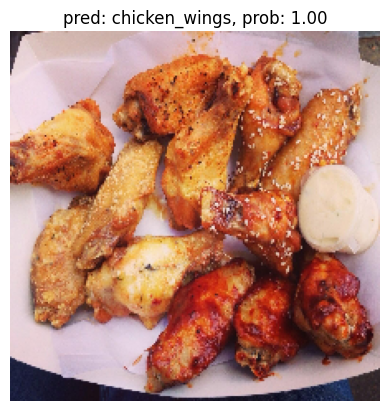

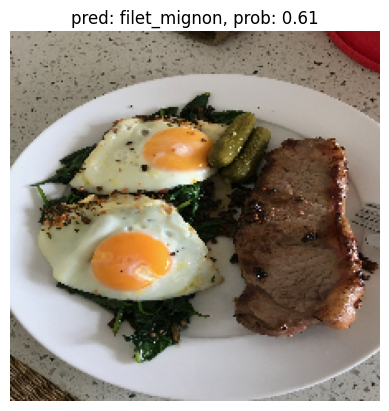

In [82]:
# Make predictions on and plot of our custom images
for img in custom_food_images:
  img = load_and_prep_images(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  # Plot the information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);

In [83]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8bc81b81-5394-248e-a3ae-aefac92b8b01)
